# DOE Study Workflow

Asynchronous DOE Workflow with DOEStudy
=======================================

Demonstrates how to use DOEStudy to persist a Design of Experiments
workflow across multiple sessions. In practice, each "session" below
would be a separate script run (days or weeks apart) with lab work
in between.

The .jaxsr file is a ZIP archive containing:
- meta.json — version, timestamps
- study.json — factor config, design spec, model config, iteration history
- X_design.npy, X_observed.npy, y_observed.npy — NumPy binary arrays

In [1]:
import numpy as np

from jaxsr import DOEStudy

## Session 1: Set up the study and create the initial design

In [2]:
print("=" * 60)
print("SESSION 1: Study setup and initial design")
print("=" * 60)

study = DOEStudy(
    name="polymer_strength",
    description="Optimize tensile strength of a polymer blend",
    factor_names=["temperature", "pressure", "additive_pct"],
    bounds=[(150, 250), (5, 20), (0, 10)],
)

# Generate a space-filling design
X_design = study.create_design(method="latin_hypercube", n_points=15, random_state=42)
print(f"Created {len(X_design)} design points:")
for i, row in enumerate(X_design):
    print(f"  Run {i + 1}: T={row[0]:.1f}°C, P={row[1]:.1f} bar, additive={row[2]:.1f}%")

# Save and share with the lab
study.save("/tmp/polymer_study.jaxsr")
print(f"\nStudy saved. {len(study.pending_points)} experiments pending.")
print(study.summary())

SESSION 1: Study setup and initial design
Created 15 design points:
  Run 1: T=211.5°C, P=16.6 bar, additive=4.1%
  Run 2: T=198.7°C, P=6.9 bar, additive=6.0%
  Run 3: T=238.3°C, P=7.2 bar, additive=8.6%
  Run 4: T=233.7°C, P=15.6 bar, additive=3.4%
  Run 5: T=172.4°C, P=13.2 bar, additive=1.0%
  Run 6: T=168.5°C, P=5.4 bar, additive=6.0%
  Run 7: T=204.5°C, P=11.4 bar, additive=0.2%
  Run 8: T=227.6°C, P=8.0 bar, additive=2.7%
  Run 9: T=158.1°C, P=9.8 bar, additive=9.0%
  Run 10: T=156.4°C, P=14.8 bar, additive=1.5%
  Run 11: T=191.7°C, P=17.0 bar, additive=9.8%
  Run 12: T=187.5°C, P=10.5 bar, additive=2.5%
  Run 13: T=249.1°C, P=19.5 bar, additive=7.8%
  Run 14: T=178.9°C, P=12.6 bar, additive=4.8%
  Run 15: T=218.7°C, P=18.7 bar, additive=6.8%

Study saved. 15 experiments pending.
DOE Study: polymer_strength
Description: Optimize tensile strength of a polymer blend
Factors: temperature, pressure, additive_pct
Bounds: [(150, 250), (5, 20), (0, 10)]

Design: 15 points (0 completed, 

## Session 2: Add first batch of lab results and fit initial model

In [3]:
print("\n" + "=" * 60)
print("SESSION 2: First batch of results")
print("=" * 60)

# Reload from disk (simulating a new Python session)
study = DOEStudy.load("/tmp/polymer_study.jaxsr")
print(f"Loaded study: {study.n_observations} observations, {len(study.pending_points)} pending")

# Simulate lab results for the first 8 experiments
# (In practice, these come from real measurements)
X_batch1 = study.design_points[:8]


SESSION 2: First batch of results
Loaded study: 0 observations, 15 pending


In [4]:
def true_response(X):
    """Simulated ground truth for the polymer system."""
    T, P, A = X[:, 0], X[:, 1], X[:, 2]
    return 50 + 0.3 * T + 1.5 * P + 2.0 * A - 0.001 * T**2 + np.random.randn(len(T)) * 2

**True response surface:** $$y = 50 + 0.3T + 1.5P + 2.0A - 0.001T^2 + \varepsilon$$

In [5]:
y_batch1 = true_response(X_batch1)

study.add_observations(X_batch1, y_batch1, notes="First 8 experiments from Lab A")
print(f"Added {len(y_batch1)} observations. Total: {study.n_observations}")

# Fit an initial model
model = study.fit(max_terms=5)
print(f"\nInitial model: {model.expression_}")
print(f"  MSE = {model._result.mse:.4f}")

# Save progress
study.save("/tmp/polymer_study.jaxsr")
print(f"\nStudy saved. {len(study.pending_points)} experiments still pending.")

Added 8 observations. Total: 8


/Users/jkitchin/Dropbox/projects/jaxsr/src/jaxsr/study.py:572: UserWarning: Removing 1 basis functions with non-finite values
  model.fit(self._X_observed, self._y_observed)



Initial model: y = 88.12 + 8.5073e-07*exp(pressure) + 0.0904*additive_pct^2
  MSE = 4.1240

Study saved. 7 experiments still pending.


## Session 3: Add remaining results and refine

In [6]:
print("\n" + "=" * 60)
print("SESSION 3: Complete results and refinement")
print("=" * 60)

study = DOEStudy.load("/tmp/polymer_study.jaxsr")
print(f"Loaded: {study.n_observations} observations, model fitted: {study.is_fitted}")
print(f"Current model: {study.model.expression_}")

# Add the remaining 7 experiments
X_batch2 = study.design_points[8:]
y_batch2 = true_response(X_batch2)
study.add_observations(X_batch2, y_batch2, notes="Remaining 7 experiments")

# Refit with all data
model = study.fit(max_terms=5)
print(f"\nRefined model: {model.expression_}")
print(f"  MSE = {model._result.mse:.4f}")

# Suggest next experiments for a follow-up round
next_points = study.suggest_next(n_points=3, strategy="space_filling")
print("\nSuggested next experiments:")
for i, row in enumerate(next_points):
    print(f"  Run {i + 1}: T={row[0]:.1f}°C, P={row[1]:.1f} bar, additive={row[2]:.1f}%")

study.save("/tmp/polymer_study.jaxsr")


SESSION 3: Complete results and refinement
Loaded: 8 observations, model fitted: True
Current model: y = 88.12 + 8.5073e-07*exp(pressure) + 0.0904*additive_pct^2


/Users/jkitchin/Dropbox/projects/jaxsr/src/jaxsr/study.py:572: UserWarning: Removing 1 basis functions with non-finite values
  model.fit(self._X_observed, self._y_observed)



Refined model: y = 94.06 + 0.1851*pressure*additive_pct - 9.0859e-07*temperature^3
  MSE = 6.6313



Suggested next experiments:
  Run 1: T=189.6°C, P=19.7 bar, additive=0.5%
  Run 2: T=154.3°C, P=18.6 bar, additive=6.0%
  Run 3: T=150.4°C, P=20.0 bar, additive=5.8%


Parameter Significance (95% CI):
             Term   Estimate   Std Err        t    p-value 95% CI
  ---------------------------------------------------------------------------
                1    94.0565    0.0000 3822152.12   0.00e+00 [94.0564, 94.0565] ***
  pressure*additive_pct     0.1851    0.0158    11.68   6.51e-08 [0.1506, 0.2196] ***
    temperature^3    -0.0000    0.0000    -6.71   2.18e-05 [-0.0000, -0.0000] ***
  --- *** p<0.001, ** p<0.01, * p<0.05


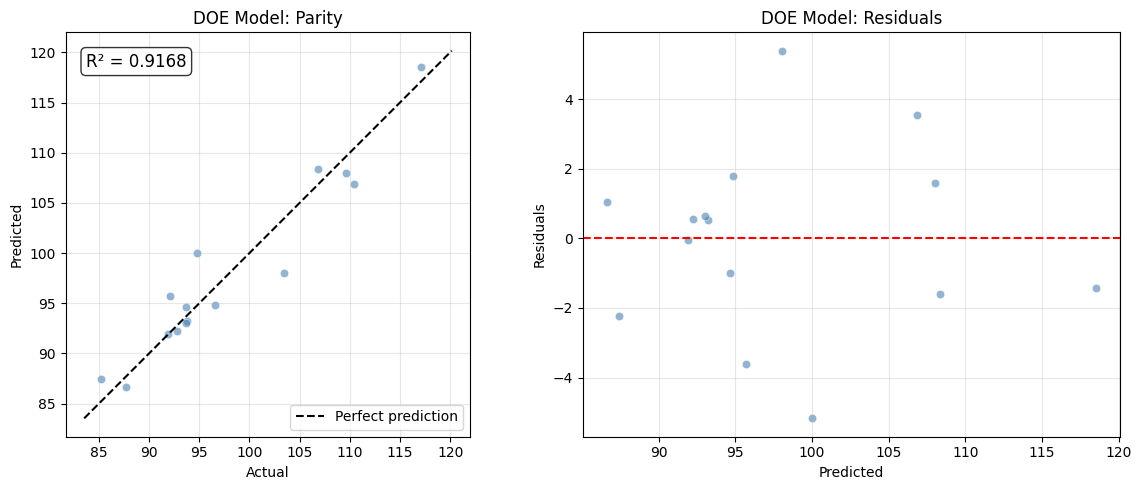


ANOVA Table (DOE Model)
  Source                       DF        Sum Sq       Mean Sq           F     p-value
--------------------------------------------------------------------------------
  1                             1        0.0001        0.0001        0.00      0.9970
  pressure*additive_pct         1      956.5759      956.5759      115.40      0.0000
  temperature^3                 1        0.0000        0.0000        0.00      1.0000
  Model                         2     1095.5592      547.7796       66.08      0.0000
  Residual                     12       99.4690        8.2891                        
  Total                        14     1195.0282       85.3592                        
--------------------------------------------------------------------------------

Variance Contributions:
  1                             0.0%  
  pressure*additive_pct       100.0%  ***
  temperature^3                 0.0%  


In [7]:
# Parameter significance, diagnostics, and ANOVA
import matplotlib.pyplot as plt
from scipy import stats as sp_stats
from jaxsr import anova
from jaxsr.plotting import plot_parity

model = study.model
X_obs = study._X_observed
y_obs = study._y_observed

intervals = model.coefficient_intervals(alpha=0.05)
n_obs, k_terms = len(np.asarray(y_obs)), len(model.selected_features_)
df_resid = n_obs - k_terms

print("Parameter Significance (95% CI):")
print(f"  {'Term':>15s} {'Estimate':>10s} {'Std Err':>9s} {'t':>8s} {'p-value':>10s} 95% CI")
print("  " + "-" * 75)
for name, (est, lo, hi, se) in intervals.items():
    t_val = est / se if abs(se) > 1e-15 else float("inf")
    p_val = float(2 * (1 - sp_stats.t.cdf(abs(t_val), df_resid))) if df_resid > 0 else 0.0
    sig = "***" if p_val < 0.001 else ("**" if p_val < 0.01 else ("*" if p_val < 0.05 else ""))
    print(f"  {name:>15s} {est:10.4f} {se:9.4f} {t_val:8.2f} {p_val:10.2e} [{lo:.4f}, {hi:.4f}] {sig}")
print("  --- *** p<0.001, ** p<0.01, * p<0.05")

y_pred = model.predict(X_obs)
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
plot_parity(y_obs, y_pred, ax=axes[0], title="DOE Model: Parity")
residuals = np.array(y_obs - y_pred)
axes[1].scatter(np.array(y_pred), residuals, alpha=0.6, c="steelblue", edgecolors="white", linewidth=0.5)
axes[1].axhline(y=0, color="r", linestyle="--")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("Residuals")
axes[1].set_title("DOE Model: Residuals")
axes[1].grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

anova_result = anova(model)
summary_sources = {"Model", "Residual", "Total"}
print("\nANOVA Table (DOE Model)")
print("=" * 80)
print(f"  {'Source':25s}  {'DF':>4}  {'Sum Sq':>12}  {'Mean Sq':>12}  {'F':>10}  {'p-value':>10}")
print("-" * 80)
for row in anova_result.rows:
    f_str = f"{row.f_value:10.2f}" if row.f_value is not None else "          "
    p_str = f"{row.p_value:10.4f}" if row.p_value is not None else "          "
    print(f"  {row.source:25s}  {row.df:4d}  {row.sum_sq:12.4f}  {row.mean_sq:12.4f}  {f_str}  {p_str}")
print("-" * 80)
term_rows = [r for r in anova_result.rows if r.source not in summary_sources]
if term_rows:
    model_ss = sum(r.sum_sq for r in term_rows)
    print("\nVariance Contributions:")
    for row in term_rows:
        pct = 100 * row.sum_sq / model_ss if model_ss > 0 else 0
        sig = (
            "***" if row.p_value is not None and row.p_value < 0.001 else (
            "**" if row.p_value is not None and row.p_value < 0.01 else (
            "*" if row.p_value is not None and row.p_value < 0.05 else ""))
        )
        print(f"  {row.source:25s}  {pct:6.1f}%  {sig}")

## Session 4: Review and share

In [8]:
print("\n" + "=" * 60)
print("SESSION 4: Review complete study")
print("=" * 60)

study = DOEStudy.load("/tmp/polymer_study.jaxsr")
print(study.summary())

# The .jaxsr file can be shared with colleagues
# They can load it and continue the analysis
print("\nFile /tmp/polymer_study.jaxsr is ready to share!")
print(f"  Schema version: {study.meta['schema_version']}")
print(f"  Created: {study.meta['created']}")
print(f"  Last modified: {study.meta['modified']}")


SESSION 4: Review complete study
DOE Study: polymer_strength
Description: Optimize tensile strength of a polymer blend
Factors: temperature, pressure, additive_pct
Bounds: [(150, 250), (5, 20), (0, 10)]

Design: 15 points (15 completed, 0 pending)
Design method: latin_hypercube
Observations: 15

Model: y = 94.06 + 0.1851*pressure*additive_pct - 9.0859e-07*temperature^3
  MSE: 6.63127
  AIC: 76.9451
  Terms: 3

Iterations: 2
  Round 1: +8 points → y = 88.12 + 8.5073e-07*exp(pressure) + 0.0904*additive_pct^2 (First 8 experiments from Lab A)
  Round 2: +7 points → y = 94.06 + 0.1851*pressure*additive_pct - 9.0859e-07*temperature^3 (Remaining 7 experiments)

Created: 2026-02-10T22:35:52.463238+00:00
Modified: 2026-02-10T22:35:55.527383+00:00

File /tmp/polymer_study.jaxsr is ready to share!
  Schema version: 1.0.0
  Created: 2026-02-10T22:35:52.463238+00:00
  Last modified: 2026-02-10T22:35:55.527383+00:00
